In [1]:
import pandas as pd
from pandas import Series,DataFrame

"""
IMPORTANT NOTE: If parsing Excel files fails, conda install xlrd AND openpyxl
"""

# BLS dataset for labor participation
bls_file = pd.ExcelFile('staadata.xlsx')
# Parse the first sheet of the excel file and set as DataFrame
header = ['FIPS Code', 'State', 'Year', 'Civilian non-institutional population',
           'Civilian labor force Total', 'CLF Percent of population', 'CLF Employment Total',
           'CLF Employment Percent of population', 'CLF Unemployment Total',
           'CLF Unemployment Rate'
          ]
bls = bls_file.parse('Sheet1', skiprows=7, names=header)
bls12 = bls[bls.Year == 2012]
bls12 = bls12[['State','CLF Employment Percent of population','CLF Unemployment Rate']]
bls12['CLF Employment Percent of population'] = pd.to_numeric(bls12['CLF Employment Percent of population'])
bls12['CLF Unemployment Rate'] = pd.to_numeric(bls12['CLF Unemployment Rate'])
bls12.set_index('State')

# 2012 Election data to determine if a state is "red" or "blue"
pres_file = pd.ExcelFile('2012pres.xls')
pres = pres_file.parse('2012 Pres General Results')
pres = pres.drop([1, 'FEC ID', 'STATE ABBREVIATION', 'GENERAL ELECTION DATE'], axis=1)
Dem = pres[pres['LAST NAME'] == 'Obama'].set_index('STATE')
Rep = pres[pres['LAST NAME'] == 'Romney'].set_index('STATE')
Dem_Rep = pd.DataFrame(Dem['GENERAL %'] - Rep['GENERAL %'])
Dem_Rep.rename(columns={'GENERAL %': 'PercentDemocratHasOverRepublican'}, inplace=True)
Dem_Rep.reset_index(level=0, inplace=True)

# Load income per capita as response variable
income = pd.read_csv('per_capita_income.csv', low_memory=False)
income = income[[1, 2]]
income.set_index('State')

# Merge data sets
data = pd.merge(Dem_Rep, income, left_on='STATE', right_on='State')
data = pd.merge(data, bls12).drop(['STATE'], axis=1).set_index('State')
data.columns = ['PercentObamaOverRomney', 'IncomePerCapita',
                'Labor Participation', 'Unemployment_2012']
data['PercentObamaOverRomney'] = pd.to_numeric(data['PercentObamaOverRomney'])
data['IncomePerCapita'] = data['IncomePerCapita'].apply(lambda x: x.replace('$', '').replace(',', ''))
data['IncomePerCapita'] = pd.to_numeric(data['IncomePerCapita'])
data['Labor Participation'] = pd.to_numeric(data['Labor Participation'])
data['Unemployment_2012'] = pd.to_numeric(data['Unemployment_2012'])
data['PercentObamaOverRomney_c'] = data['PercentObamaOverRomney'] - data['PercentObamaOverRomney'].mean()
data.head()

,PercentObamaOverRomney,IncomePerCapita,Labor Participation,Unemployment_2012,PercentObamaOverRomney_c
State,,,,,
Alabama,-0.221868,23606,53.4,8.0,-0.227431
Alaska,-0.139889,33062,63.4,7.1,-0.145452
Arizona,-0.090648,25715,55.5,8.3,-0.096210
Arkansas,-0.236879,22883,54.8,7.6,-0.242442
California,0.231186,30441,56.6,10.4,0.225623


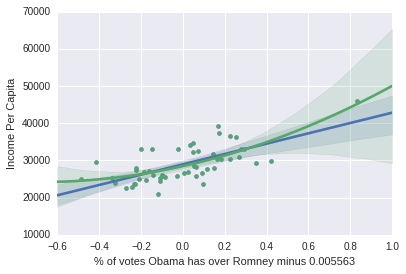

In [2]:
# Run first order and second order regression to see which fit better
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

# fit second order polynomial
# run the 2 scatterplots together to get both linear and second order fit lines
scat1 = seaborn.regplot(x="PercentObamaOverRomney_c", y="IncomePerCapita", scatter=True, data=data)
scat1 = seaborn.regplot(x="PercentObamaOverRomney_c", y="IncomePerCapita", scatter=True, order=2, data=data)
plt.xlabel('% of votes Obama has over Romney minus 0.005563')
plt.ylabel('Income Per Capita')

In [3]:
# linear regression analysis
import statsmodels.formula.api as smf
reg1 = smf.ols('IncomePerCapita ~ PercentObamaOverRomney_c', data=data).fit()
print (reg1.summary())

                            OLS Regression Results                            
Dep. Variable:        IncomePerCapita   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     43.22
Date:                Sun, 14 Aug 2016   Prob (F-statistic):           2.56e-08
Time:                        23:51:10   Log-Likelihood:                -507.72
No. Observations:                  53   AIC:                             1019.
Df Residuals:                      51   BIC:                             1023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

In [4]:
# quadratic (polynomial) regression analysis
reg2 = smf.ols('IncomePerCapita ~ PercentObamaOverRomney_c + I(PercentObamaOverRomney_c**2)',
               data=data).fit()
print (reg2.summary())

                            OLS Regression Results                            
Dep. Variable:        IncomePerCapita   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     24.13
Date:                Sun, 14 Aug 2016   Prob (F-statistic):           4.61e-08
Time:                        23:51:10   Log-Likelihood:                -506.08
No. Observations:                  53   AIC:                             1018.
Df Residuals:                      50   BIC:                             1024.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

In [5]:
# Rsquare only increased 3% when going from linear to quadratic
# Is unemployment rate a confounding variable, no
data['Unemployment_2012_c'] = (data['Unemployment_2012'] - data['Unemployment_2012'].mean())
reg3 = smf.ols('IncomePerCapita  ~ PercentObamaOverRomney_c + I(PercentObamaOverRomney_c**2) + Unemployment_2012_c', 
               data=data).fit()
print (reg3.summary())

                            OLS Regression Results                            
Dep. Variable:        IncomePerCapita   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     19.30
Date:                Sun, 14 Aug 2016   Prob (F-statistic):           2.13e-08
Time:                        23:51:10   Log-Likelihood:                -503.32
No. Observations:                  53   AIC:                             1015.
Df Residuals:                      49   BIC:                             1023.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercep

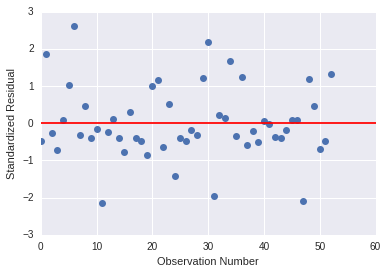

In [6]:
# simple plot of residuals, outliers exceed 3 standard deviations
stdres= DataFrame(reg3.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

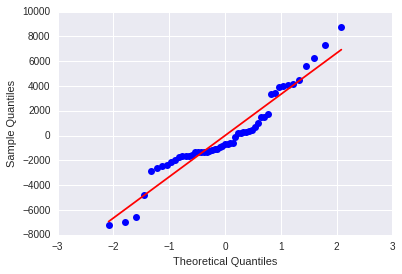

In [7]:
# Q-Q plot for normality, residuals should follow straight red line if normally distributed
import statsmodels.api as sm
fig4=sm.qqplot(reg3.resid, line='r')

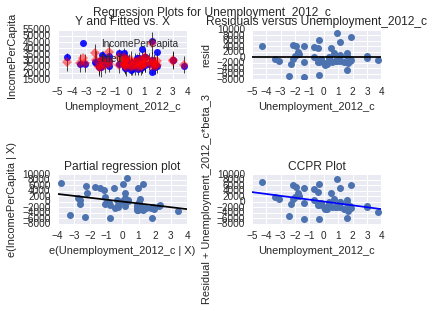

In [8]:
# Q-Q plot says our residual is NOT normally distributed, run additional diagnostic
fig2 = plt.figure()
fig2 = sm.graphics.plot_regress_exog(reg3,  "Unemployment_2012_c", fig=fig2)

Figure(480x320)


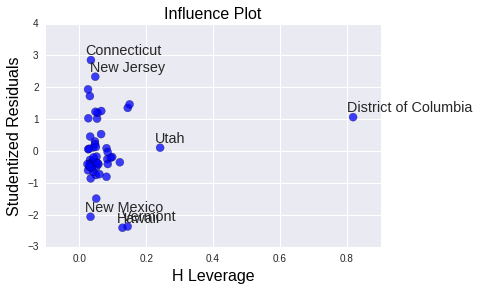

In [9]:
# leverage plot, |residuals| > 2 stdev are outliers
fig3=sm.graphics.influence_plot(reg3, size=8)
print(fig3)

In [10]:
# Connecticut is an outlier by its weight is small, high leverage on DC but it's only 1 stdev off.